In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 1. Считать данные
df = pd.read_csv('housing.csv')
# Ограничиваем размер датасета до 12 %, так пришлось сделать потому что в колабе не хватало памяти на большее количество записей
df = df.sample(frac=0.12, random_state=42)
# 2. Описание датасета
print(df.info())
print(df.describe())
print(df.head())

# Предобработка данных
# Удалим строки с пропущенными значениями
df = df.dropna()

# Кодирование категориальных признаков
label_encoder = LabelEncoder()
df['ocean_proximity'] = label_encoder.fit_transform(df['ocean_proximity'])

# Разделение признаков и целевой переменной
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Масштабирование числовых признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ограничение размера выборки для подбора гиперпараметров
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Пайплайн для дерева решений
pipeline = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

# Подбор гиперпараметров
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sample, y_train_sample)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Метрики на обучающей выборке
y_train_pred = best_estimator.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("Best parameters (Decision Tree):", best_params)
print("Train MSE:", mse_train)
print("Train MAE:", mae_train)
print("Train R2:", r2_train)

# Метрики на тестовой выборке
y_test_pred = best_estimator.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R2:", r2_test)

# Важность признаков
importances = best_estimator.named_steps['regressor'].feature_importances_
features = X.columns.tolist()

feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Фильтрация признаков по важности
threshold = 0.01
important_features = feature_importance_df[feature_importance_df['importance'] > threshold]['feature']

# Преобразование данных
X_train_transformed_df = pd.DataFrame(X_train, columns=features)
X_test_transformed_df = pd.DataFrame(X_test, columns=features)

# Фильтрация признаков в преобразованных данных
X_train_filtered = X_train_transformed_df[important_features]
X_test_filtered = X_test_transformed_df[important_features]

# Пайплайн для дерева решений с фильтрованными признаками
pipeline_filtered = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

grid_search_filtered = GridSearchCV(pipeline_filtered, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_filtered.fit(X_train_filtered, y_train)

best_params_filtered = grid_search_filtered.best_params_
best_estimator_filtered = grid_search_filtered.best_estimator_

# Метрики на обучающей выборке с фильтрованными признаками
y_train_pred_filtered = best_estimator_filtered.predict(X_train_filtered)
mse_train_filtered = mean_squared_error(y_train, y_train_pred_filtered)
mae_train_filtered = mean_absolute_error(y_train, y_train_pred_filtered)
r2_train_filtered = r2_score(y_train, y_train_pred_filtered)

print("Best parameters (Decision Tree, filtered):", best_params_filtered)
print("Train MSE (filtered):", mse_train_filtered)
print("Train MAE (filtered):", mae_train_filtered)
print("Train R2 (filtered):", r2_train_filtered)

# Метрики на тестовой выборке с фильтрованными признаками
y_test_pred_filtered = best_estimator_filtered.predict(X_test_filtered)
mse_test_filtered = mean_squared_error(y_test, y_test_pred_filtered)
mae_test_filtered = mean_absolute_error(y_test, y_test_pred_filtered)
r2_test_filtered = r2_score(y_test, y_test_pred_filtered)

print("Test MSE (filtered):", mse_test_filtered)
print("Test MAE (filtered):", mae_test_filtered)
print("Test R2 (filtered):", r2_test_filtered)

# Сравнение метрик до и после фильтрации признаков
metrics_comparison = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Mean Absolute Error', 'R2 Score'],
    'Before Filtering': [mse_train, mae_train, r2_train],
    'After Filtering': [mse_train_filtered, mae_train_filtered, r2_train_filtered]
})
print(metrics_comparison)

# 4. Случайный лес
# Пайплайн для случайного леса
pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

param_grid_rf = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__max_features': [None, 'sqrt', 'log2']
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_sample, y_train_sample)

best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_

# Метрики на обучающей выборке
y_train_pred_rf = best_estimator_rf.predict(X_train)
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
precision_train_rf = precision_score(y_train, y_train_pred_rf, average='macro')
recall_train_rf = recall_score(y_train, y_train_pred_rf, average='macro')
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='macro')

print("Best parameters (Random Forest):", best_params_rf)
print("Train Accuracy:", accuracy_train_rf)
print("Train Precision:", precision_train_rf)
print("Train Recall:", recall_train_rf)
print("Train F1 Score:", f1_train_rf)

# Метрики на тестовой выборке
y_test_pred_rf = best_estimator_rf.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
precision_test_rf = precision_score(y_test, y_test_pred_rf, average='macro')
recall_test_rf = recall_score(y_test, y_test_pred_rf, average='macro')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print("Test Accuracy:", accuracy_test_rf)
print("Test Precision:", precision_test_rf)
print("Test Recall:", recall_test_rf)
print("Test F1 Score:", f1_test_rf)

# Фильтрация признаков для случайного леса
importances_rf = best_estimator_rf.named_steps['classifier'].feature_importances_
feature_importance_df_rf = pd.DataFrame({'feature': features, 'importance': importances_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='importance', ascending=False)
print(feature_importance_df_rf)

important_features_rf = feature_importance_df_rf[feature_importance_df_rf['importance'] > threshold]['feature']

X_train_filtered_rf = X_train_transformed_df[important_features_rf]
X_test_filtered_rf = X_test_transformed_df[important_features_rf]

# Пайплайн для случайного леса с фильтрованными признаками
pipeline_rf_filtered = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

grid_search_rf_filtered = GridSearchCV(pipeline_rf_filtered, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf_filtered.fit(X_train_filtered_rf, y_train)

best_params_rf_filtered = grid_search_rf_filtered.best_params_
best_estimator_rf_filtered = grid_search_rf_filtered.best_estimator_

# Метрики на обучающей выборке с фильтрованными признаками
y_train_pred_rf_filtered = best_estimator_rf_filtered.predict(X_train_filtered_rf)
accuracy_train_rf_filtered = accuracy_score(y_train, y_train_pred_rf_filtered)
precision_train_rf_filtered = precision_score(y_train, y_train_pred_rf_filtered, average='macro')
recall_train_rf_filtered = recall_score(y_train, y_train_pred_rf_filtered, average='macro')
f1_train_rf_filtered = f1_score(y_train, y_train_pred_rf_filtered, average='macro')

print("Best parameters (Random Forest, filtered):", best_params_rf_filtered)
print("Train Accuracy (filtered):", accuracy_train_rf_filtered)
print("Train Precision (filtered):", precision_train_rf_filtered)
print("Train Recall (filtered):", recall_train_rf_filtered)
print("Train F1 Score (filtered):", f1_train_rf_filtered)

# Метрики на тестовой выборке с фильтрованными признаками
y_test_pred_rf_filtered = best_estimator_rf_filtered.predict(X_test_filtered_rf)
accuracy_test_rf_filtered = accuracy_score(y_test, y_test_pred_rf_filtered)
precision_test_rf_filtered = precision_score(y_test, y_test_pred_rf_filtered, average='macro')
recall_test_rf_filtered = recall_score(y_test, y_test_pred_rf_filtered, average='macro')
f1_test_rf_filtered = f1_score(y_test, y_test_pred_rf_filtered, average='macro')

print("Test Accuracy (filtered):", accuracy_test_rf_filtered)
print("Test Precision (filtered):", precision_test_rf_filtered)
print("Test Recall (filtered):", recall_test_rf_filtered)
print("Test F1 Score (filtered):", f1_test_rf_filtered)

# 5. KNN
# Пайплайн для KNN
pipeline_knn = Pipeline(steps=[
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_sample, y_train_sample)

best_params_knn = grid_search_knn.best_params_
best_estimator_knn = grid_search_knn.best_estimator_

# Метрики на обучающей выборке
y_train_pred_knn = best_estimator_knn.predict(X_train)
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
precision_train_knn = precision_score(y_train, y_train_pred_knn, average='macro')
recall_train_knn = recall_score(y_train, y_train_pred_knn, average='macro')
f1_train_knn = f1_score(y_train, y_train_pred_knn, average='macro')

print("Best parameters (KNN):", best_params_knn)
print("Train Accuracy:", accuracy_train_knn)
print("Train Precision:", precision_train_knn)
print("Train Recall:", recall_train_knn)
print("Train F1 Score:", f1_train_knn)

# Метрики на тестовой выборке
y_test_pred_knn = best_estimator_knn.predict(X_test)
accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
precision_test_knn = precision_score(y_test, y_test_pred_knn, average='macro')
recall_test_knn = recall_score(y_test, y_test_pred_knn, average='macro')
f1_test_knn = f1_score(y_test, y_test_pred_knn, average='macro')

print("Test Accuracy:", accuracy_test_knn)
print("Test Precision:", precision_test_knn)
print("Test Recall:", recall_test_knn)
print("Test F1 Score:", f1_test_knn)

# Сравнение метрик на тестовой выборке для всех моделей
metrics_comparison_test = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'KNN'],
    'Test Accuracy': [accuracy_test_rf, accuracy_test_rf, accuracy_test_knn],
    'Test Precision': [precision_test_rf, precision_test_rf, precision_test_knn],
    'Test Recall': [recall_test_rf, recall_test_rf, recall_test_knn],
    'Test F1 Score': [f1_test_rf, f1_test_rf, f1_test_knn]
})
print(metrics_comparison_test)


<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 20046 to 1444
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           2477 non-null   float64
 1   latitude            2477 non-null   float64
 2   housing_median_age  2477 non-null   float64
 3   total_rooms         2477 non-null   float64
 4   total_bedrooms      2270 non-null   float64
 5   population          2477 non-null   float64
 6   households          2477 non-null   float64
 7   median_income       2477 non-null   float64
 8   median_house_value  2477 non-null   float64
 9   ocean_proximity     2477 non-null   object 
dtypes: float64(9), object(1)
memory usage: 212.9+ KB
None
         longitude     latitude  housing_median_age   total_rooms  \
count  2477.000000  2477.000000         2477.000000   2477.000000   
mean   -119.522317    35.590690           28.896245   2602.330642   
std       1.997713     2.146393         

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Best parameters (Random Forest): {'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__n_estimators': 100}
Train Accuracy: 0.1261013215859031
Train Precision: 0.020976448751060264
Train Recall: 0.10070248567613521
Train F1 Score: 0.029957124085022515
Test Accuracy: 0.02643171806167401
Test Precision: 0.0028483072916666665
Test Recall: 0.003146701388888889
Test F1 Score: 0.002976190476190476
              feature  importance
7       median_income    0.179458
1            latitude    0.139112
0           longitude    0.137625
2  housing_median_age    0.114766
5          population    0.106110
3         total_rooms    0.097757
4      total_bedrooms    0.093205
6          households    0.092100
8     ocean_proximity    0.039868


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters (Random Forest, filtered): {'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__n_estimators': 100}
Train Accuracy (filtered): 0.32819383259911894
Train Precision (filtered): 0.3041352193844527
Train Recall (filtered): 0.27087375075517367
Train F1 Score (filtered): 0.27735614748189596


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Test Accuracy (filtered): 0.039647577092511016
Test Precision (filtered): 0.0009631997188219078
Test Recall (filtered): 0.005311355311355311
Test F1 Score (filtered): 0.001287778288815992
Best parameters (KNN): {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Train Accuracy: 0.031938325991189426
Train Precision: 0.001534825304998702
Train Recall: 0.017088274044795782
Train F1 Score: 0.0020090856542557627
Test Accuracy: 0.01762114537444934
Test Precision: 0.0018952854773750295
Test Recall: 0.0009476427386875148
Test F1 Score: 0.001263523651583353
           Model  Test Accuracy  Test Precision  Test Recall  Test F1 Score
0  Decision Tree       0.026432        0.002848     0.003147       0.002976
1  Random Forest       0.026432        0.002848     0.003147       0.002976
2            KNN       0.017621        0.001895     0.000948       0.001264


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


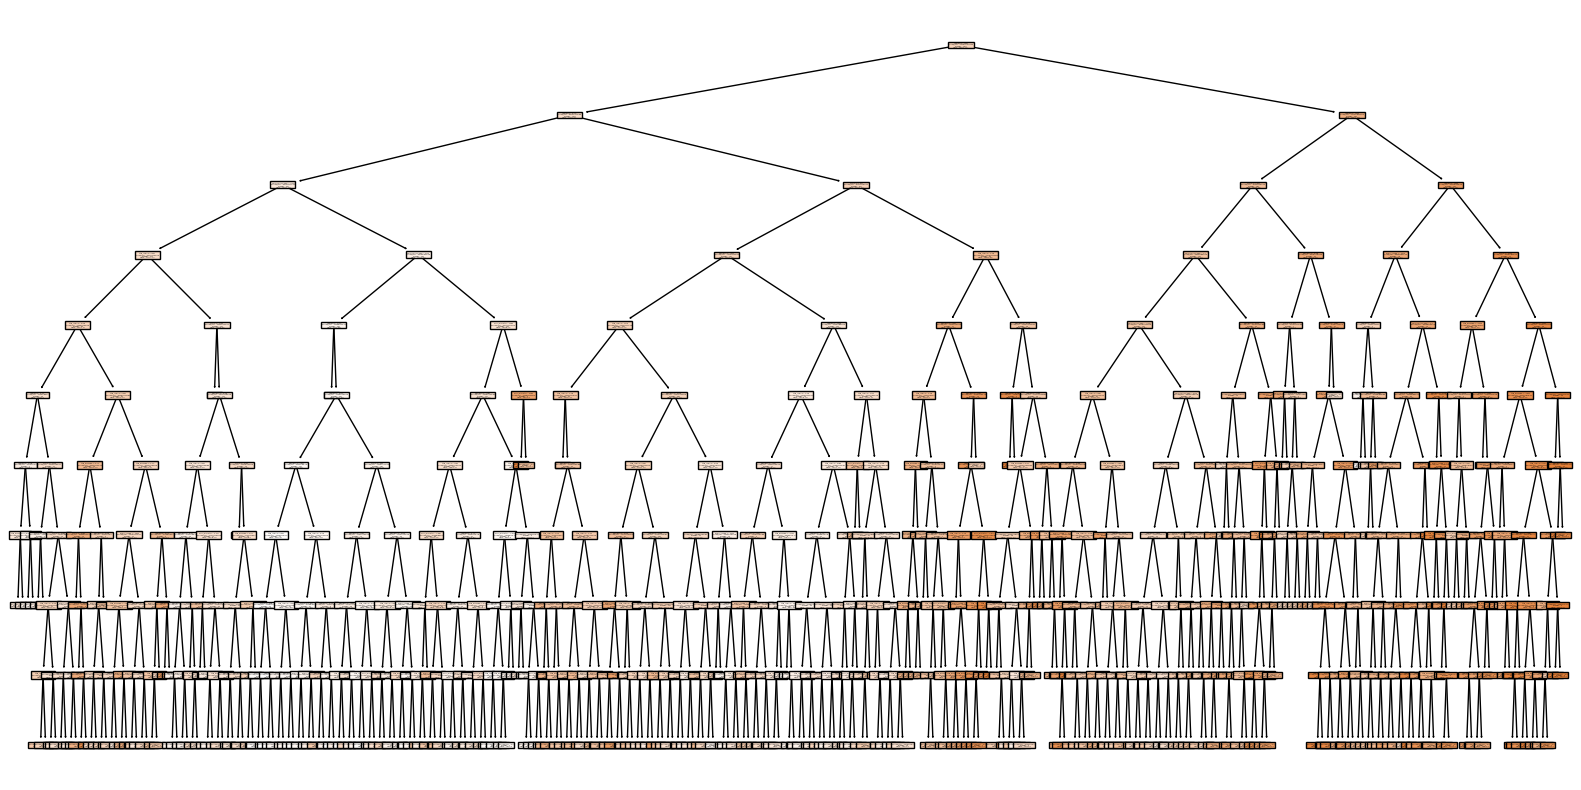

In [9]:
# Визуализация дерева решений
plt.figure(figsize=(20,10))
plot_tree(best_estimator_filtered.named_steps['regressor'], feature_names=important_features, filled=True)
plt.show()